# Packages and Functions

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from itertools import product

import geopandas as gpd
import rasterio
# import geowombat as gw
from rasterio import features
from rasterio.transform import Affine
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.enums import Resampling as ResamplingEnum
from rasterio.enums import MergeAlg
from rasterio.fill import fillnodata

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Python and ML Learnings with AI COE\\Spatial Programming & Remote Sensing'

# Reading and Writing Rasters with Rasterio

In order to work with raster data we will be using rasterio and later `geowombat`. Behind the scenes a `numpy.ndarray` does all the heavy lifting. To understand how raster works it helps to construct one from scratch.

Here we create two ndarray objects one X spans [-90°,90°] longitude, and Y covers [-90°,90°] latitude.

In [66]:
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

X, Y

(array([[-90., -54., -18.,  18.,  54.,  90.],
        [-90., -54., -18.,  18.,  54.,  90.],
        [-90., -54., -18.,  18.,  54.,  90.],
        [-90., -54., -18.,  18.,  54.,  90.],
        [-90., -54., -18.,  18.,  54.,  90.],
        [-90., -54., -18.,  18.,  54.,  90.]]),
 array([[ 90.,  90.,  90.,  90.,  90.,  90.],
        [ 54.,  54.,  54.,  54.,  54.,  54.],
        [ 18.,  18.,  18.,  18.,  18.,  18.],
        [-18., -18., -18., -18., -18., -18.],
        [-54., -54., -54., -54., -54., -54.],
        [-90., -90., -90., -90., -90., -90.]]))

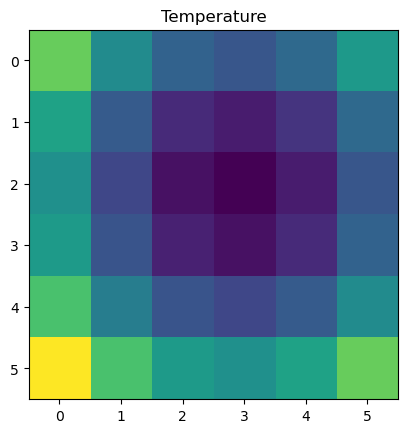

In [67]:
Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

## Creating Raster Data

The final array `Z` still lacks a number of elements that transform it from being a non-spatial `numpy` array to a spatial one usable by `rasterio` etc. Rasterio requires the following elements to write out a geotif, or spatial raster dataset:

| Parameters | Description | Argument |
| --- | --- | --- |
| driver | The name of the desired format driver | `GTiff` |
| width | the number of columns in the dataset | `Z.shape[1]` |
| height | the number of rows in the dataset | `Z.shape[0]` |
| count | a count of the dataset bands | `1` |
| dtype | the data type of the dataset | `Z.dtype` |
| crs | a coordinate reference system identified or description | `+proj=latlong` |
| transform | an affine transformation matrix | `Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)` |
| nodata | a "nodata" value | `-9999` |

Recall, `transform` defines the location of the upper left hand corner of the raster on the globe, and its spatial resolution. 

## Writing Rasters

To save this array along with spatial information to a file, we call `rasterio.open()` with a path to the new file to be created, and ‘w’ to specify writing mode, along with the arguments above.

In [68]:
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)

transform = Affine.translation(x[0] - xres / 2, y[0] / 2) * Affine.scale(xres, yres)

with rasterio.open(
    os.getcwd() + '/data/temperature.tif',
    mode = 'w',
    driver = 'GTiff',
    height = Z.shape[0],
    width = Z.shape[1],
    count = 1,
    dtype = Z.dtype,
    crs = '+proj=latlong',
    transform = transform,
    nodata = -9999
) as new_dataset:
    new_dataset.write(Z, 1)

When we go to look again at our data we can read it back in using open. Before plotting we `raster.read(1)` the first band, which converts the data back to a `numpy` array that can be plotted in `matplotlib`. Notice that we also specify the band number (in this case 1), with `.write(Z, 1)`.

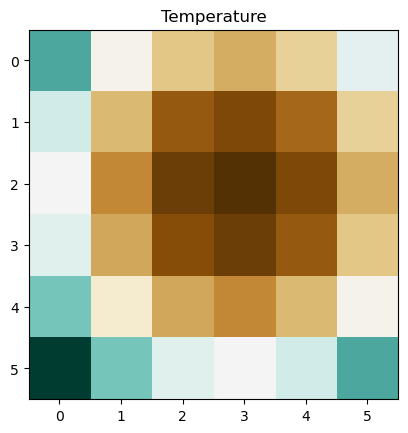

In [69]:
raster = rasterio.open(os.getcwd() + '/data/temperature.tif')

plt.imshow(raster.read(1), cmap = 'BrBG')
plt.title('Temperature')
plt.show()

So in summary, a spatial dataset is essentially just a `numpy.ndarray` with information about the location and resolution of the array, the coordinate reference system, and number of bands. This information is typically accessed and updated via the `.profile`.

In [70]:
print(raster.profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 45.0), 'blockysize': 6, 'tiled': False, 'interleave': 'band'}


## Update Raster Metadata

Notice the the `.profile` above is missing a meaningful nodata value and was uncompressed. Let’s learn how to update these values. For this we can update the `.profile` dictionary.

In [71]:
# Start with the original profile
profile = raster.profile

# Update values for nodata and compression type
profile.update(nodata = 0, compress = 'lzw')
print(profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0, 'width': 6, 'height': 6, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(30.0, 0.0, -105.0,
       0.0, -30.0, 45.0), 'blockysize': 6, 'tiled': False, 'interleave': 'band', 'compress': 'lzw'}


Now we just need to write the array of data (obtained from `raster.read(1)`) out with the updated profile info. We can unpack all the dictionary values from the profile using `**profile`.

In [72]:
with rasterio.open(
    os.getcwd() + '/data/temperature_2.tif',
    mode = 'w',
    **profile,
) as update_dataset:
    update_dataset.write(raster.read(1), 1)

## Rasterio Multiband Rasters

Working with multiband imagery starts to get a bit tricky, especially with `rasterio` alone.

Let’s start with a problematic raster file, a landsat image that stores its red, green, and blue bands in reverse order (blue, green, red), that is scaled by 100 (multiplied by 100 to store data as integers rather than float), and that is missing a meaningful nodata value.

In [73]:
with rasterio.open(
    os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF',
    mode = 'r', nodata = 0
) as src:
    # Read in the array, band 3 first, then band 2, then band 1
    arr = src.read([3, 2, 1])

    # The array has three bands
    print('Array shape: ', arr.shape)

    # Look at the profile, despite setting nodata = 0, there still isn't a nodata value
    # We need to update the profile first and write out a new image with nodata set
    profile = src.profile
    print(profile)

Array shape:  (3, 1860, 2041)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2041, 'height': 1860, 'count': 3, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 717345.0,
       0.0, -30.0, -2776995.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


We use `src.read([3, 2, 1])` in order to reverse the read order of our bands. With this the original blue, green, red order is read in reverse as red, green, blue, which is required for true color images.

To see what it looks like, let’s use rasterio’s `show` function which *sort of helps* when viewing multiband imagery.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [6672 6168 6100 ... 6028 6015 6008]
  [6291 6457 6423 ... 6021 6001 6017]
  [6181 6727 6747 ... 6098 6023 5991]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [7083 6794 6731 ... 6760 6724 6685]
  [6951 7079 7016 ... 6699 6687 6715]
  [6864 7286 7338 ... 6817 6732 6659]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [7692 7518 7513 ... 7440 7432 7415]
  [7586 7590 7610 ... 7440 7411 7425]
  [7576 7743 7770 ... 7464 7443 7406]]]
--------------------------------


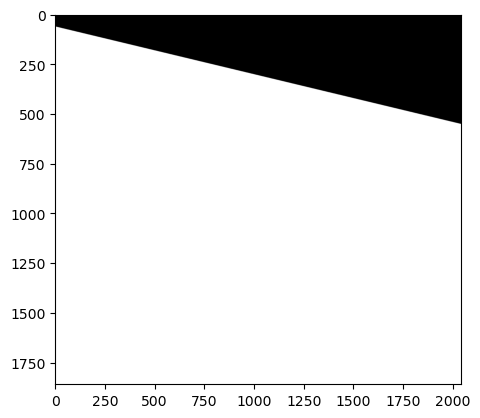

<AxesSubplot: >

In [74]:
print(arr)
print('--------------------------------')
show(arr)

Arg… it looks terrible. A few things, the primary problem is that the zeros aren’t being treated as missing data, and therefor messing everything up. Second, there is a message at the top of the image saying its `clipping... [0..255] `for `integers`).

Let’s check what the range of values are in our raster. To do this we will use `scipy` `stats`, and `.ravel()` to convert our `n` dimension array to a `1d` array.

In [75]:
print(stats.describe(arr.ravel()))

DescribeResult(nobs=11388780, minmax=(0, 24147), mean=6095.312502656123, variance=7725568.744020711, skewness=-1.6071105370358574, kurtosis=0.9303298625510847)


Since we currently have integer data that ranges from 0 to 24147, we should try scaling it, if we go to the documentation we would see that we need to divide all values by 100.

In [76]:
scaled_arr = arr / 100
print(scaled_arr.dtype)

float64


Then let's write the data back out again with an updated profile. Notice that the datatype (`dtype`) has changed since we divided by 100.

In [77]:
# Update the profile for the new raster
profile = src.profile
profile.update(nodata = 0, compress = 'lzw', dtype = scaled_arr.dtype)

# Write out raster as RGB
with rasterio.open(
    os.getcwd() + '/data/LS_scaled_20200518.tif',
    mode = 'w',
    **profile, # Unpack the profile arguments set above
) as new_dataset:
    new_dataset.write(scaled_arr, [1, 2, 3])

Since the bands have already been put in the right order in the array (ie. RGB), we can just write it out as follows `.write(scaled_arr, [1, 2, 3])`.

There you go! A fixed raster. Try opening it in Qgis to make sure. We can look at it now using rasterio `show`, but again it isn’t great, but better.

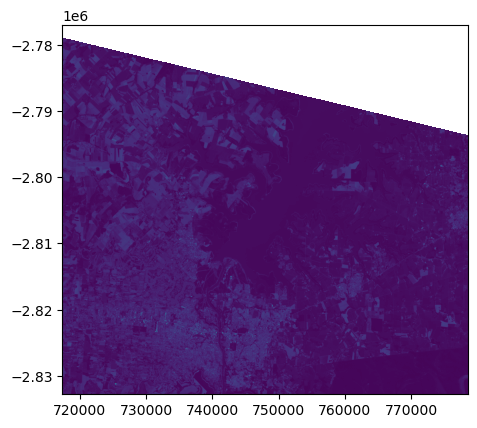

In [78]:
with rasterio.open(
    os.getcwd() + '/data/LS_scaled_20200518.tif', 
    mode = 'r', 
) as src:
    show(src, adjust = 'linear')

Here's how to do this in `geowombat`:

In [79]:
# fig, ax = plt.subplots(dpi = 200)

# # Tell geowombat to read a blue green red
# with gw.config.update(sensor = 'bgr'):
#     with gw.open(os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF') as src:
#         # See that bands names, blue green red are assigned
#         print(src.band)

#         # Remove 0 value, rearrange band order
#         temp = src.where(src != 0).sel(band = ['red', 'green', 'blue'])

#         # Plot
#         temp.gw.imshow(robust = True, ax = ax)

#         # Save to file
#         temp.gw.save(
#             os.getcwd() + '/data/LS_scaled_20200518.tif',
#             n_workers = 4,
#             overwrite = True
#         )

# Reproject Rasters with Rasterio and Geowombat

## Reprojecting a Raster with Geowombat

Far and away the easiest way to handle raster data is by using geowombat. Here’s an example of quickly and easily reprojecting a three band landsat image, and writing it to disk.

In order to reproject on the fly we are going to open the raster using `gw.config.update()`. The configuration manager allows easy control over opened raster dimensions, alignment, and transformations. All we need to do is pass a `ref_crs` to the configuration manager. We can also use the resampling method when we open the image, by default it will be `nearest`, but you can also choose one of [‘average’, ‘bilinear’, ‘cubic’, ‘cubic_spline’, ‘gauss’, ‘lanczos’, ‘max’, ‘med’, ‘min’, ‘mode’, ‘nearest’].

In [80]:
# proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
# image = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

# with gw.config.update(ref_crs = proj4):
#     with gw.open(image, resampling = "nearest") as src:
    
#         src.gw.save(
#             os.getcwd() + "/data/LC08_20200518_aea.tif",
#             n_workers = 4,  # number of process workers 
#             overwrite = True,
#         ) 

Let’s take a look, remember from earlier that this image is stored as green, blue, red (rather than red, green, blue), so we will use `.sel(band = [3, 2, 1])` to put them back in the right order.

In [81]:
# fig, ax = plt.subplots(dpi = 200)

# image = os.getcwd() + '/data/LC08_20200518_aea.tif'
# with gw.open(image) as src:
#     src.where(src != 0).sel(band = [3, 2, 1]).gw.imshow(robust = True, ax = ax)
#     plt.tight_layout(pad = 1)

Too easy? Want something more complex? Try the same thing with Rasterio. Yes, there will be a little matrix algebra.

## `calculate_default_transform` explained

How do we reproject a raster? Before we get into it, we need to talk some more… about `calculate_default_transform`. `calculate_default_transform` allows us to **generate the transform matrix required for the new reprojected raster based on the characteristics of the original and the desired output CRS**. Note that the `source` (src) is the original input raster, and the `destination` (dst) is the outputed reprojected raster.

First, remember that the transform matrix takes the following form:

$$ \text{Transform} = \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} $$

Now let's calculate the transform matrix for the destination raster:

In [82]:
dst_crs = 'EPSG:3857'

with rasterio.open(os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF') as src:
    # Transform for input raster
    src_transform = src.transform

    # Calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,        # source CRS
        dst_crs,        # destination CRS 
        src.width,      # column count
        src.height,     # row count
        *src.bounds,    # unpacks outer boundaries (left, bottom, right, top)
    )

print('Source Transform:\n', src_transform, "\n")
print('Destination Transform:\n', dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


Notice that in order to keep the same number of rows and columns that the resolution of the destination raster increased from 30 meters to 33.24 meters. Also, the coordinates of the upper left hand corner have shifted (check $ \Delta x $, $ \Delta y $).

## Reprojecting a Raster with Rasterio

Ok finally~

In [83]:
dst_crs = 'EPSG:3857' # Web mercator (i.e. google maps)

with rasterio.open(os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF') as src:
    src_transform = src.transform
    
    # Calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,
    )

    # Set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            'crs': dst_crs,
            'transform': dst_transform,
            'width': width,
            'height': height,
            'nodata': 0 # Replace 0 with np.nan
        }
    )

    with rasterio.open(os.getcwd() + '/data/LC08_20200518_webMC.tif', 'w', **dst_kwargs) as dst:
        # Iterate through bands
        for i in range(1, src.count + 1):
            reproject(
                source = rasterio.band(src, i),
                destination = rasterio.band(dst, i),
                src_transform = src.transform,
                src_crs = src.crs,
                dst_transform = dst_transform,
                dst_crs = dst_crs,
                resampling = Resampling.nearest,
            )

# Resampling & Registering Rasters with Rasterio and Geowombat

## Why is Resampling Important?

Before you begin any analysis using raster data, it is critical that you have rasters that are “co-registered”. **Co-registration** requires that **any two rasters have the same resolution, and orientation** - the origins can differ but they much align. In other words, co-registration requires that **cell centroids align perfectly for all intersecting areas**. Resampling is also extremely common during reprojection operations as it often requires changing the orientation, scale or resolution of an image.

Examples of data that is not co-registered:

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Raster_diff-orientation.jpg'>
</p>

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Raster_diff-orientation-origin.jpg'>
</p>

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Raster_diff-res.jpg'>
</p>

We can co-register images by resampling, and often reprojecting, one image to match another.

There are a number of methods to resample data, but they often take the form of “nearest neighbor”, “bilinear”, and “cubic convolusion” - these interpolation methods are explained here in some detail. But there are a number of other including: [‘average’, ‘cubic_spline’, ‘gauss’, ‘lanczos’, ‘max’, ‘med’, ‘min’, ‘mode’, ‘nearest’].

Here are the different **resampling directions**:
- Upsampling  - convert to higher resolution/smaller cells
- Downsampling - convert to lower resolution/smaller cells

## Simple Up/Downsampling in Rasterio & Geowombat

### Rasterio Upsampling Example

Occasionally, you will need to resample your data by some factor, for instance you might want data upsampled to a courser resolution due to memory constraints.

Here’s an example of how to generate the data array and the transform needed to write it out. We will start by simply reading in the data and coersing a higher resolution, by adding more rows and columns. To understand the transform, let’s review affine transformations. Here we will update the scale values with the new resolution using $S_y$ and $S_x$ show below:

$$ \text{Scale transform: } \begin{bmatrix} S_x & 0 & 0 \\ 0 & S_y & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

In [84]:
image = os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.tif'

upscale_factor = 2

with rasterio.open(image) as dataset:
    # Resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape = (
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling = ResamplingEnum.bilinear
    )

    print('Shape before resample: ', dataset.shape)
    print('Shape after resample: ', data.shape[1:])

    # Scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    print('Transform before resample:\n', dataset.transform, '\n')
    print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output
    # dst_kwargs = src.meta.copy()
    # dst_kwargs.update(
    #     {
    #         "crs": dst_crs,
    #         "transform": dst_transform,
    #         "width": data.shape[-1],
    #         "height": data.shape[-2],
    #         "nodata": 0,  
    #     }
    # )

    # with rasterio.open(os.getcwd() + "/data/LC08_20200518_15m.tif", "w", **dst_kwargs) as dst:
    #     # iterate through bands
    #     for i in range(data.shape[0]):
    #           dst.write(data[i].astype(rasterio.uint32), i + 1)

Shape before resample:  (1860, 2041)
Shape after resample:  (3720, 4082)
Transform before resample:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 15.00, 0.00, 717345.00|
| 0.00,-15.00,-2776995.00|
| 0.00, 0.00, 1.00|


### Geowombat Up/Down Sampling Example

As always, the easiest way to deal with resampling is by deploying `geowombat`. It’s like a swiss army knife for kicking raster butt. Here we just need to set the desired resolution with `ref_res`, and the `resampling` method in the open statement. We have a number of resampling methods available depending on the context listed above. Writing a file is a bit more intuitive too.

In [85]:
# with gw.config.update(ref_res = 15):
#     with gw.open(image, resampling = "bilinear") as src:
#         print(src)
        
#         # to write out simply:
#         # src.gw.save(
#         #     os.getcwd() + "/data/LC08_20200518_15m.tif",
#         #     overwrite=True,
#         # ) 

## Co-registering Rasters (Aligning cells)

One common problem is how to get raster data to align on a cell by cell basis so you can complete your analysis. We will walk through how to do this for both rasterio and geowombat. In the following example we will learn how to align rasters with different origins, resolutions, or orientations.

Our example data will look at registering LandSat data with precipitation data from CHIRPS.

### Example of Co-Registering Rasters with Rasterio

Co-registering data is a bit complicated with `rasterio` -- you need to choose an “reference image” to match the bounds, CRS, and cell size.

The original input data LandSat data is 30 meters and will be downsampled to match precip which is 500m. Also note the use of nodata to avoid missing values stored as 0. Note we can choose a number of resampling techniques listed above. For more detail on resampling go to Introduction to Raster CRS.

In [86]:
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of the existing raster.

    Args:
        infile (string): Path to input file to reproject
        match (string): Path to raster with desired shape and projection
        outfile (string): Path to output file tif
    """

    # Open input
    with rasterio.open(infile) as src:
        src_transform = src.transform

        # Open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs

            # Calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,        # Input CRS
                dst_crs,        # Output CRS
                match.width,    # Input width
                match.height,   # Input height
                *match.bounds,  # Unpacks input outer boundaries (left, bottom, right, top)
            )
        
        # Set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                'crs': dst_crs,
                'transform': dst_transform,
                'width': dst_width,
                'height': dst_height,
                'nodata': 0,
            }
        )
        print('Coregistered to shape: ', dst_height, dst_width, "\n Affine", dst_transform)

        # Open output
        with rasterio.open(outfile, 'w', **dst_kwargs) as dst:
            # Iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source = rasterio.band(src, i),
                    destination = rasterio.band(dst, i),
                    src_transform = src.transform,
                    src_crs = src.crs,
                    dst_transform = dst_transform,
                    dst_crs = dst_crs,
                    resampling = Resampling.nearest
                )

Now we can execute out code to co-register two rasters.

In [87]:
LS = os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF'
precip = os.getcwd() + '/data/precipitation_20200601_500m.tif'

# Co-register LS to match precip raster
reproj_match(infile = LS, match = precip, outfile = os.getcwd() + '/data/LS_reg_precip.tif')

Coregistered to shape:  136 157 
 Affine | 0.00, 0.00,-61.49|
| 0.00,-0.00,-0.00|
| 0.00, 0.00, 1.00|


### Example of Co-registering Rasters with Geowombat

Co-registering data is simple in geowombat, you simply need to choose an “reference image” to match the bounds, CRS, and cell size.

The original input data precip is currently 500m but will be upsampled to 30m as seen in print(src). Also note the use of nodata to avoid missing values stored as -9999. Note we can choose a number of `resampling` techniques listed above.

In [88]:
# with gw.config.update(ref_image = LS):
#     with gw.open(precip, resampling = 'bilinear', nodata = -9999) as src:
#         print(src)
#         ax.imshow(src.data[0])

#         # To write out simply:
#         # src.gw.save(
#         #    os.getcwd() + '/data/precip_20200601_30m.tif',
#         #    overwrite = True,
#         # )

Also note that geowombat’s built in .imshow functionality doesn’t currently work for single band images. To get an image we have to extract a `np.ndarray` that has the shape `(1, 1860, 2041)`. Where `(1,.,.)` is the band, so to get a 2d array we select `data[0]`. We also avoid missing values (-9999).

# Band Math with Rasterio

Band math is useful when you want to perform a mathematical operation to each pixel value in a raster. You might find band math helpful for calculating NDVI or multiplying all values by a constant.

`Rasterio` makes band math relatively straightforward since the rasters are essentially read in as `numpy` arrays, so you can perform math on the raster arrays just like any numpy array.

Mathematical operations on rasters using `rasterio` are not spatially aware. Any mathematical operation with multiple rasters will work even if the rasters are not representing the same geographical extent. Consequently, you need to ensure that the cell size and extent represented in all rasters are the same. In other words, if you are using two rasters in a mathematical operation, they must have the same shape (same number of rows and columns).

In this example we will write two raster files to the disk: `math_raster_a.tif` and `math_raster_b.tif`. We will then read then back in and do math on them. Let’s generate some rasters.

In [89]:
# Generate mesh grid for rasters
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

# Generate values for mesh grid
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z3 = np.abs(((X + 3) + (Y - 8) ** 2) / 3 ** 2)

# Generate raster values for two rasters
Z_a = (Z1 - Z2)
Z_b = (Z2 - Z3)

# Set transform
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

# Save first raster
with rasterio.open(
        os.getcwd() + "/data/math_raster_a.tif",
        mode = "w",
        driver = "GTiff",
        height = Z_a.shape[0],
        width = Z_a.shape[1],
        count = 1,
        dtype = Z_a.dtype,
        crs = "+proj=latlong",
        transform = transform,
) as new_dataset:
        new_dataset.write(Z_a, 1)

# Save second raster
with rasterio.open(
        os.getcwd() + "/data/math_raster_b.tif",
        mode = "w",
        driver = "GTiff",
        height = Z_b.shape[0],
        width = Z_b.shape[1],
        count = 1,
        dtype = Z_b.dtype,
        crs = "+proj=latlong",
        transform = transform,
) as new_dataset:
        new_dataset.write(Z_b, 1)

Let's view the raster values.

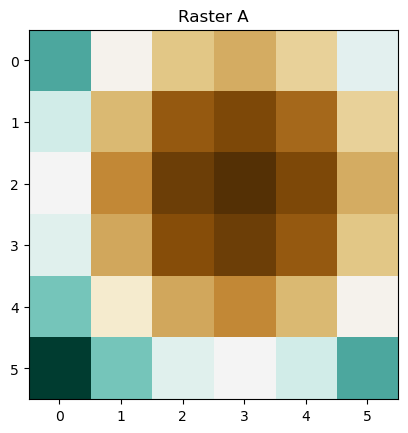

[[13776.    8586.24  5573.76  4738.56  6080.64  9600.  ]
 [10256.64  5066.88  2054.4   1219.2   2561.28  6080.64]
 [ 8914.56  3724.8    712.32  -122.88  1219.2   4738.56]
 [ 9749.76  4560.    1547.52   712.32  2054.4   5573.76]
 [12762.24  7572.48  4560.    3724.8   5066.88  8586.24]
 [17952.   12762.24  9749.76  8914.56 10256.64 13776.  ]]


In [90]:
# Open raster and plot
raster_a = rasterio.open(os.getcwd() + '/data/math_raster_a.tif').read(1)
plt.imshow(raster_a, cmap = 'BrBG')
plt.title('Raster A')
plt.show()

# View raster values
print(raster_a)

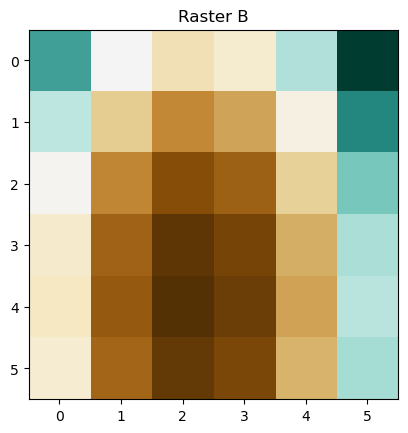

[[1886.55555556 1168.31555556  864.79555556  975.99555556 1501.91555556
  2442.55555556]
 [1453.91555556  735.67555556  432.15555556  543.35555556 1069.27555556
  2009.91555556]
 [1147.99555556  429.75555556  126.23555556  237.43555556  763.35555556
  1703.99555556]
 [ 968.79555556  250.55555556  -52.96444444   58.23555556  584.15555556
  1524.79555556]
 [ 916.31555556  198.07555556 -105.44444444    5.75555556  531.67555556
  1472.31555556]
 [ 990.55555556  272.31555556  -31.20444444   79.99555556  605.91555556
  1546.55555556]]


In [91]:
# Open raster and plot
raster_b = rasterio.open(os.getcwd() + '/data/math_raster_b.tif').read(1)
plt.imshow(raster_b, cmap = 'BrBG')
plt.title('Raster B')
plt.show()

# View raster values
print(raster_b)

## Example band math operations

We can get the difference between the two rasters.

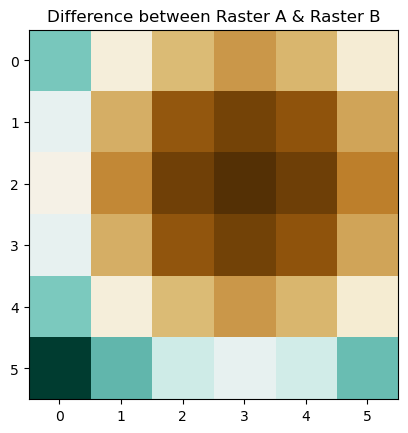

Raster values:
 [[11889.44444444  7417.92444444  4708.96444444  3762.56444444
   4578.72444444  7157.44444444]
 [ 8802.72444444  4331.20444444  1622.24444444   675.84444444
   1492.00444444  4070.72444444]
 [ 7766.56444444  3295.04444444   586.08444444  -360.31555556
    455.84444444  3034.56444444]
 [ 8780.96444444  4309.44444444  1600.48444444   654.08444444
   1470.24444444  4048.96444444]
 [11845.92444444  7374.40444444  4665.44444444  3719.04444444
   4535.20444444  7113.92444444]
 [16961.44444444 12489.92444444  9780.96444444  8834.56444444
   9650.72444444 12229.44444444]]


In [92]:
# Get difference
difference_a_b = raster_a - raster_b

# Plot raster
plt.imshow(difference_a_b, cmap = 'BrBG')
plt.title('Difference between Raster A & Raster B')
plt.show()

# Show raster values
print('Raster values:\n', difference_a_b)

We can multiply a raster by a constant.

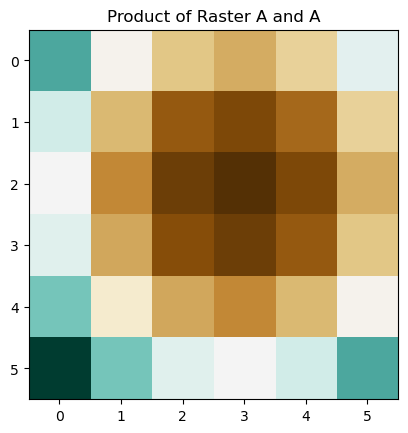

Raster values:
 [[27552.   17172.48 11147.52  9477.12 12161.28 19200.  ]
 [20513.28 10133.76  4108.8   2438.4   5122.56 12161.28]
 [17829.12  7449.6   1424.64  -245.76  2438.4   9477.12]
 [19499.52  9120.    3095.04  1424.64  4108.8  11147.52]
 [25524.48 15144.96  9120.    7449.6  10133.76 17172.48]
 [35904.   25524.48 19499.52 17829.12 20513.28 27552.  ]]


In [93]:
# Get product
product_a = raster_a * 2

# Plot raster
plt.imshow(product_a, cmap = 'BrBG')
plt.title('Product of Raster A and A')
plt.show()

# Show raster values
print('Raster values:\n', product_a)

## Band math with NoData values

If a pixel has a value of `nan`, `None`, or `NoData` value, those pixels will automatically be ignored in any band math. The output raster will maintain the `nan`, `None`, or `NoData` value at that pixel location.

Not all rasters, however, use those values to signify that a pixel has no value. Some rasters might use 0 or another number to indicate no value. In that case, we have to explicitly mark that pixel to be skipped.

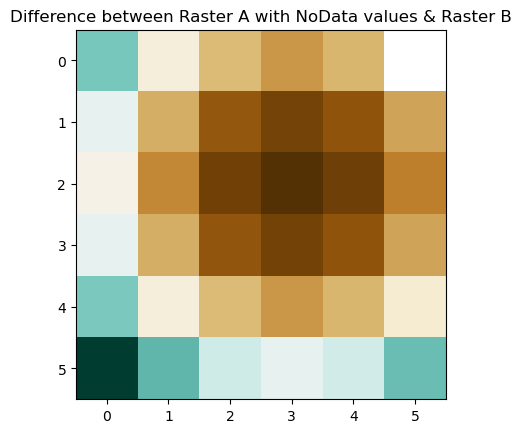

Raster values:
 [[11889.444444444445 7417.924444444445 4708.964444444445
  3762.564444444444 4578.724444444444 --]
 [8802.724444444444 4331.204444444445 1622.2444444444445
  675.8444444444445 1492.0044444444443 4070.7244444444436]
 [7766.564444444444 3295.0444444444447 586.0844444444443
  -360.31555555555553 455.84444444444455 3034.564444444444]
 [8780.964444444444 4309.444444444444 1600.4844444444443
  654.0844444444443 1470.2444444444445 4048.964444444445]
 [11845.924444444445 7374.404444444444 4665.444444444444
  3719.0444444444447 4535.204444444445 7113.924444444445]
 [16961.444444444445 12489.924444444445 9780.964444444444
  8834.564444444444 9650.724444444444 12229.444444444445]]


In [94]:
# Create a copy of first raster
raster_0 = raster_a.copy()

# Set a pixel value to 0 as an example, which will signify NoData (top right pixel)
raster_0[0, 5] = 0

# Mask out any NoData (0) values
raster_0_masked = np.ma.masked_array(raster_0, mask = (raster_0 == 0))

# Get difference between masked raster and second raster
difference_0_b = raster_0_masked - raster_b

# Plot raster
plt.imshow(difference_0_b, cmap = 'BrBG')
plt.title('Difference between Raster A with NoData values & Raster B')
plt.show()

# Show raster values
print('Raster values:\n', difference_0_b)

## Example: Calculating NDVI

In the example below, we will read in a clipped Landsat 8, Collection 2 Level-2 image and use the band math concepts to calculate the **normalized difference vegetation index (NDVI)** for the image. As you may recall, NDVI is a spectral approach used to assess vegetation. The formula for NDVI is:

$$ NDVI = \frac{NIR - Red}{NIR + Red} $$

where `NIR` is the near-infrared band and `Red` is the red band.

High NDVI values (towards 1) reflect a higher density of green vegetation, and low values (towards -1) reflect a lower density.

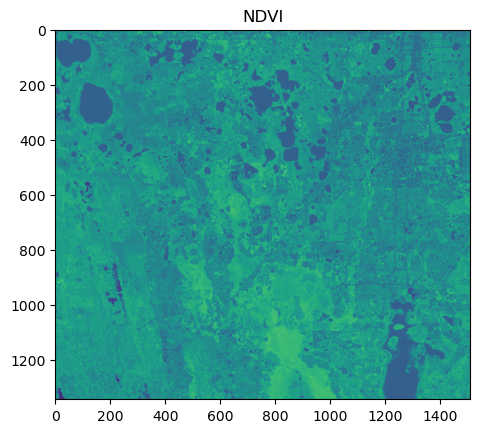

Raster values:
 [[0.1045768  0.08932138 0.09787864 ... 0.21016596 0.27657979 0.24717701]
 [0.07188325 0.1010677  0.1213656  ... 0.22981464 0.24469611 0.23835025]
 [0.03591049 0.14069341 0.17257186 ... 0.22467695 0.2150974  0.21510794]
 ...
 [0.27475696 0.24538079 0.24003341 ... 0.2692435  0.26424982 0.2754381 ]
 [0.28198954 0.26983464 0.25958875 ... 0.26693343 0.2685162  0.25831458]
 [0.27442722 0.28693113 0.2514506  ... 0.27998016 0.28904986 0.2745722 ]]


In [95]:
# Open raster (Landsat 8, Collection 2 Level-2)
# Band 1- Blue, Band 2 - Green, Band 3 - Red, Band 4 - Near Infrared
with rasterio.open(os.getcwd() + '/data/LC08_L2SP_016040_20210317_20210328_02_T1_clip.tif', mode = 'r', nodata = 0) as src:
    # Get red band
    band_red = src.read(3)

    # Get NIR band
    band_nir = src.read(4)

    # Allow division by zero
    np.seterr(divide = 'ignore', invalid = 'ignore')

    # Calculate NDVI
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red.astype(float))

# Set pixels whose values are outside the NDVI range (-1, 1) to NaN
# These are likely due to error in the Landsat imagery
ndvi[ndvi > 1] = np.nan
ndvi[ndvi < -1] = np.nan

# Plot raster
plt.imshow(ndvi)
plt.title('NDVI')
plt.show()

# Show raster values
print('Raster values:\n', ndvi)

# Replacing Values with Rasterio

Imagery may sometimes have errors due to factors such as noise, distortion, or sensor errors. Some pixels may have extremely high or low values or no value at all. One way to resolve this issue is to manually replace a pixel value with another pixel value. Another option is to interpolate the pixel value based on the values of the pixel’s neighbors.

We’ll explore how to replace raster values with rasterio.

In [96]:
# Generate mesh grid for rasters
x = np.linspace(-90, 90, 200)
y = np.linspace(90, -90, 200)
X, Y = np.meshgrid(x, y)

# Generate values for mesh grid
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)

# Generate raster values
Z = (Z1 - Z2)

# Set transform
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

# Save raster
with rasterio.open(
        os.getcwd() + '/data/replace_values_raster.tif',
        mode = "w",
        driver = "GTiff",
        height = Z.shape[0],
        width = Z.shape[1],
        count = 1,
        dtype = Z.dtype,
        crs = "+proj=latlong",
        transform = transform,
) as new_dataset:
        new_dataset.write(Z, 1)

CPLE_AppDefinedError: Deleting c:/Users/gilramolete/OneDrive - UNIONBANK of the Philippines/Documents 1/Python and ML Learnings with AI COE/Spatial Programming & Remote Sensing/data/replace_values_raster.tif failed: Permission denied

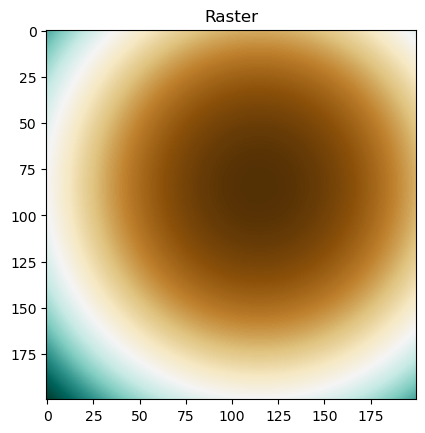

In [ ]:
# Open raster and plot
raster_file = rasterio.open(os.getcwd() + '/data/replace_values_raster.tif')
raster = raster_file.read(1)
plt.imshow(raster, cmap = 'BrBG')
plt.title('Raster')
plt.show()

## Replace values with a specfied number

Let’s say that we want to change the pixel value at row 150, column 100 because it’s wrong. We can simply call that pixel value by its row index and column index.

In [ ]:
# Replace value with 0 at one location
raster[150, 100] = 0
raster[150, 100]

0.0

We can also change multiple pixel values by slicing. In this case, we replace the values in rows 99-101 and columns 6-8 with the value 0.

In [ ]:
# Replace values with 0 at multiple locations
raster[99:102, 6:9] = 0
raster[99:102, 6:9]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Finally, we can change any pixel values that are of a certain value.

In [ ]:
raster[raster >= 13776] = 0
raster

array([[    0.        , 13618.93851165, 13463.25153405, ...,
         9371.19123254,  9484.9083609 ,  9600.        ],
       [13660.9083609 , 13503.84687255, 13348.15989495, ...,
         9256.09959344,  9369.8167218 ,  9484.9083609 ],
       [13547.19123254, 13390.1297442 , 13234.4427666 , ...,
         9142.38246509,  9256.09959344,  9371.19123254],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        13234.4427666 , 13348.15989495, 13463.25153405],
       [    0.        ,     0.        ,     0.        , ...,
        13390.1297442 , 13503.84687255, 13618.93851165],
       [    0.        ,     0.        ,     0.        , ...,
        13547.19123254, 13660.9083609 ,     0.        ]])

## Replace values through interpolation

Sometimes, we don’t know or have an exact value to replace pixel values with. We can “fill in” those pixel values through interpolation. Recall that interpolation uses the pixel values surrounding a certain pixel to determine the value for that certain pixel.

In the following example, we will interpolate the values for the pixels that were previously set to 0.

`Rasterio` provides a function `fillnodata()` that does this for us. In addition to specifying a raster, we also need to provide a mask, which tells the function which pixel values need to be filled in. The mask can either be an array of Boolean values (`True` or `False`, where `False` indicates pixels to be filled in) or numbers (where values equal to 0 indicate pixels to be filled in and values equal to `1` indicate pixels to ignore). Please note that the mask must be in the same shape (number of rows and columns) as that of the input raster.

Below, we will interpret the pixels whose values were previously set to `0`.

In [ ]:
# Create a Boolean mask (True/False) with a value of False for pixels that equal 0
mask_boolean = (raster != 0)
mask_boolean

array([[False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False]])

In [ ]:
# Create a value mask with a value of 0 for pixels that equal 0
mask_numbers = np.zeros_like(raster)
mask_numbers[raster > 0] = 255
mask_numbers

array([[  0., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255.,   0.]])

In [ ]:
# Fill in missing values with interpolation; we can use either a Boolean mask or a value mask
fillnodata(raster, mask = mask_boolean, max_search_distance = 1000)

array([[13604.37988281, 13618.93847656, 13463.25195312, ...,
         9371.19140625,  9484.90820312,  9600.        ],
       [13660.90820312, 13503.84667969, 13348.16015625, ...,
         9256.09960938,  9369.81640625,  9484.90820312],
       [13547.19140625, 13390.12988281, 13234.44238281, ...,
         9142.3828125 ,  9256.09960938,  9371.19140625],
       ...,
       [13687.77148438, 13674.72460938, 13698.35644531, ...,
        13234.44238281, 13348.16015625, 13463.25195312],
       [13698.04101562, 13686.17285156, 13709.640625  , ...,
        13390.12988281, 13503.84667969, 13618.93847656],
       [13688.7734375 , 13672.33984375, 13704.9375    , ...,
        13547.19140625, 13660.90820312, 13618.93847656]])

In [ ]:
# Print raster array
raster

array([[13604.37988281, 13618.93847656, 13463.25195312, ...,
         9371.19140625,  9484.90820312,  9600.        ],
       [13660.90820312, 13503.84667969, 13348.16015625, ...,
         9256.09960938,  9369.81640625,  9484.90820312],
       [13547.19140625, 13390.12988281, 13234.44238281, ...,
         9142.3828125 ,  9256.09960938,  9371.19140625],
       ...,
       [13687.77148438, 13674.72460938, 13698.35644531, ...,
        13234.44238281, 13348.16015625, 13463.25195312],
       [13698.04101562, 13686.17285156, 13709.640625  , ...,
        13390.12988281, 13503.84667969, 13618.93847656],
       [13688.7734375 , 13672.33984375, 13704.9375    , ...,
        13547.19140625, 13660.90820312, 13618.93847656]])

In [ ]:
# Print subset of raster around row 150, column 150
raster[148:153, 98:103]

array([[2835.38891602, 2813.02954102, 2792.04467773, 2772.43432617,
        2754.19824219],
       [2923.72485352, 2901.36547852, 2880.38061523, 2860.77026367,
        2842.53417969],
       [3013.43530273, 2991.07592773, 2978.80517578, 2950.48071289,
        2932.24462891],
       [3104.52050781, 3082.16088867, 3061.17602539, 3041.56567383,
        3023.32983398],
       [3196.97998047, 3174.62036133, 3153.63549805, 3134.02514648,
        3115.78930664]])

In [ ]:
# Print subset of raster around rows 99-101, columns 6-8
raster[97:104, 4:11]

array([[8391.83398438, 8240.27050781, 8090.08154297, 7941.26757812,
        7793.82763672, 7647.76220703, 7503.07128906],
       [8410.0703125 , 8258.50683594, 8108.31787109, 7959.50341797,
        7812.06347656, 7665.99804688, 7521.30712891],
       [8429.68066406, 8278.1171875 , 8072.66064453, 7934.33056641,
        7755.44726562, 7685.60839844, 7540.91748047],
       [8450.66503906, 8299.1015625 , 8203.32421875, 7863.87109375,
        7767.40527344, 7706.59326172, 7561.90234375],
       [8473.02441406, 8321.4609375 , 8150.89306641, 7999.92822266,
        7799.43115234, 7728.95263672, 7584.26171875],
       [8496.75878906, 8345.1953125 , 8195.00683594, 8046.19189453,
        7898.75195312, 7752.68652344, 7607.99560547],
       [8521.8671875 , 8370.30371094, 8220.11523438, 8071.30029297,
        7923.86035156, 7777.79492188, 7633.10400391]])

# Rasterize Vectors with Rasterio

Rasterizing vectors can be helpful if you want to incorporate vector data (i.e., point, line, or polygon) in your raster analysis. The process is essentially what the name suggests: We take a vector and convert it into pixels. This can be done with `rasterio`.

We’ll read in the vector file of some of California’s counties. We will also read in a raster file to get the raster’s metadata (i.e., coordinate system) so that we can apply those parameters to the vector file. In other words, the raster will serve as a “reference” for the the rasterization of the vector. In particular, we are going to **match the shape (number of rows and columns)** and the **transform (UL corner location, cell size etc)**. Please note - the vector and raster must be in the same coordinate system. If not, you’ll need to re-project one of them so they are the same. To re-project vectors, see the chapter on Understanding CRS Codes. To re-project rasters, see the chapter on Reproject Rasters w. Rasterio and Geowombat.

One important parameter in this function is `all_touched` which determines how zones are determined by polygons relative to the reference raster’s cell centroids. Setting it to `False` implies that membership in a zone, defined by a polygon geometry, should be defined by whether it contains the centroid of a cell. `True` includes any cell that geometry boundary intersects.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/zonal_stats.jpg'>
</p>

In [ ]:
# Read in vector
vector = gpd.read_file(os.getcwd() + '/data/static/sf_bay_counties/sf_bay_counties.shp')

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

# Open example raster
raster = rasterio.open(os.getcwd() + '/data/bay-area-wells_kde_sklearn.tif')

## Rasterize Binary Values for Shapes

With our data loaded, we can rasterize the vector using the metadata from the raster using `rasterize()` in the `rasterio.features` module.

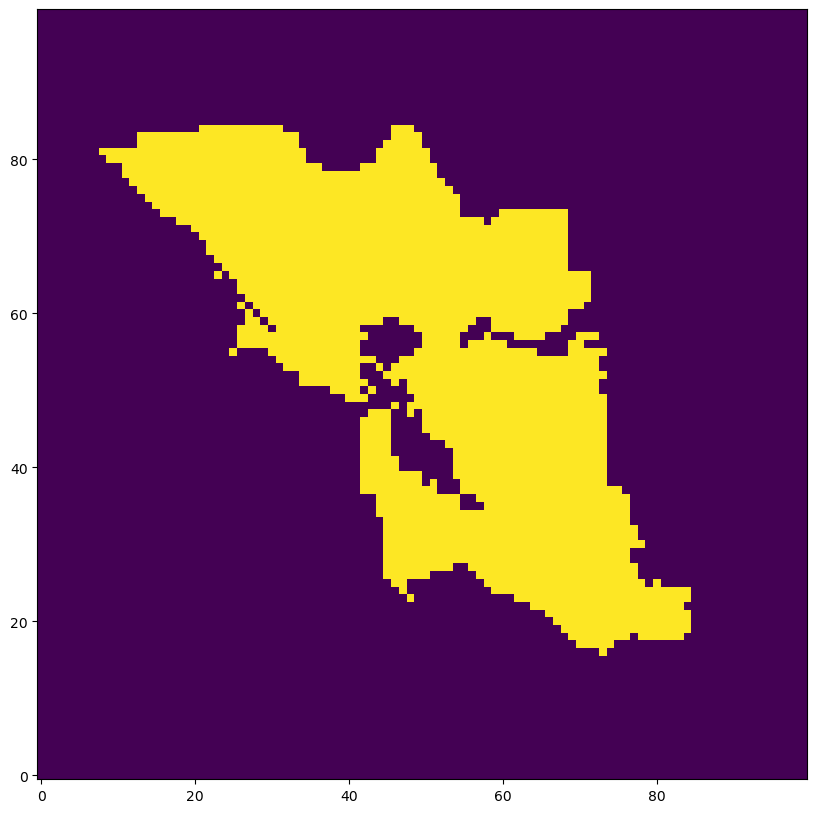

In [ ]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(
    geom,
    out_shape = raster.shape,
    fill = 0,
    out = None,
    transform = raster.transform,
    all_touched = False,
    default_value = 1,
    dtype = None
)

# Plot raster
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()
plt.show()

## Rasterize Attribute Value using Rasterio

Often we want to burn in the value of a shapefile’s attributes to the raster. We can do this by creating geometry, value pairs. In this example we take create a columns called `id` and assign the same values as the index. `id` will then be used to create our (geometry, value) pairs used for rasterization.

Note we use `all_touched = True` to avoid gaps between counties, which can introduce its own problems because two counties can compete for the same cell.

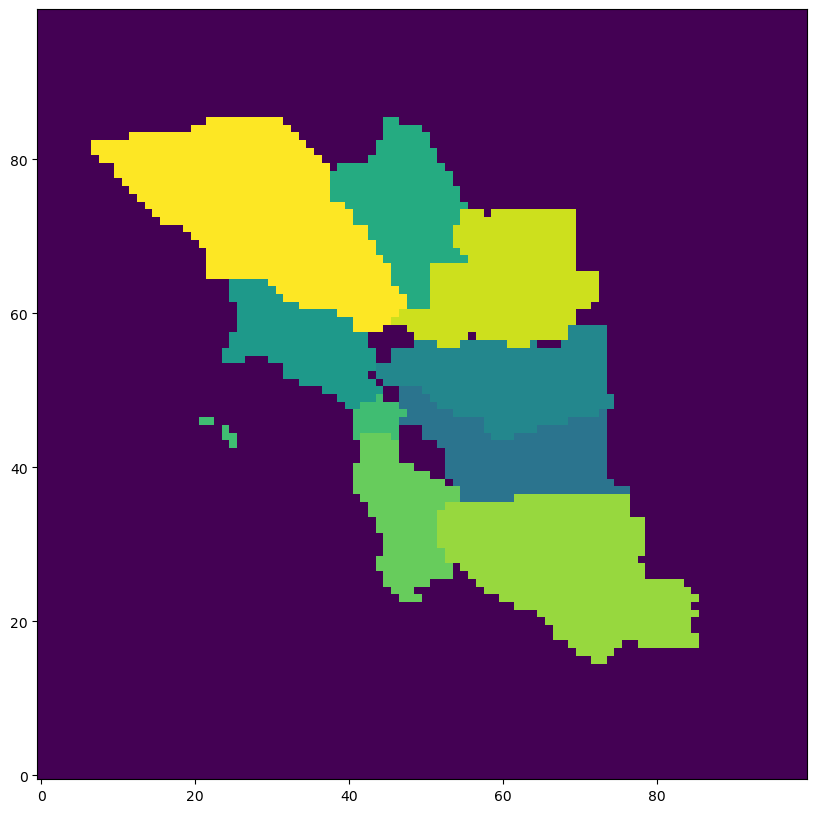

In [ ]:
# Create a numeric unique value for each row
vector['id'] = range(0, len(vector))

# Create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom, value) for geom, value in zip(vector.geometry, vector['id']))

# Rasterize vector using the shape and transform of the raster
rasterized = features.rasterize(
    geom_value,
    out_shape = raster.shape,
    transform = raster.transform,
    all_touched = True,
    fill = -5,  # background value
    merge_alg = MergeAlg.replace,
    dtype = np.int16
)

# Plot raster
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()
plt.show()

Finally, we can save the rasterized vector out.

In [ ]:
with rasterio.open(
    os.getcwd() + '/data/rasterized_vector.tif',
    'w',
    driver = 'GTiff',
    transform = raster.transform,
    dtype = rasterio.uint8,
    count = 1,
    width = raster.width,
    height = raster.height
) as dst:
    dst.write(rasterized, indexes = 1)

# Window Operations with Rasterio & GeoWombat

**Moving windows** or **filters** are often used in raster analysis. For example, they can be used to obtain the maximum value within a certain neighborhood, to smooth out values, or detect holes or edges (i.e., where pixel values that are near each other change abruptly).

These moving windows can also be called **filters** or **kernels**. They can be of many different sizes and shapes (the most common is 3-cell-by-3-cell rectangular window) and can have different or the same values for each cell. The **center of the filter** can be called the **target cell** or the **center pixel**, and the surrounding cells are referred to as the neighbors.

The filter **passes through all non-edge cells** in the raster. During each pass of the filter, the center cell is updated based on the cells adjacent to it. In the `3x3` filter example, the center cell is updated by the eight cells that neighbor it. The filter then pulls the values from the neighboring cells and the center pixel itself, performs a calculation based on the filter values (e.g., calculates the mean), reports that resulting value back to the identical location of the original pixel, moves to the next pixel, and repeats the process.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/raster_sliding_window.jpg'>
</p>

The filter values can essentially be any number –- they can be the same across the filter or be all different. The values determine how the output is calculated (equation below assuming a 3x3 filter for nine cells total in the kernel):

$$ X_w = \sum^9_{i = 1}X_ik_i $$
where $X_i$ is the raster cell value, $k_i$ is the kernel cell value, $i$ is the index of cells in the nine kernel cell values.

The values also determine what is calculated. For example, setting all filter values to `1` will result in the filter outputting the sum of all raster pixel values within the filter. Setting all filter values to `1/9` for a `3x3` filter will result in the filter outputting the average of all raster pixel values within the filter.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/raster_window_operations.jpg'>
</p>

With window operations, the edge pixels will generally be cut out from the output because those edge pixels do not have neighboring pixels all around it. As window operations generally require a pixel to be surrounded on all four sides, we cannot perform calculations on these edge pixels. The pixels that constitute the “edge” depends on the shape of the kernel. For example, a `3x3` kernel only requires 1 neighboring pixel in each direction, so only the outer ring of pixels will be cut out from the output. A `5x5` kernel requires 2 neighboring pixels in each direction, so the two outer rings of pixels will be cut out.

### Window operations with `rasterio`

The most intuitive way to perform window operations in Python is to use a `for` loop. With this method, we would **iterate through each non-edge pixel**, **obtain the surrounding pixel values and the center pixel value**, perform some sort of calculation, report that resulting value back to the identical location of the original pixel, move to the next pixel, and repeat the process. Iterating through each pixel, however, has the potential to be extremely time and computationally intensive (there could be many, many pixels).

To mitigate this limitation, instead of using a `for` loop, we can **get each neighbor value simultaneously for all non-edge pixels**. Another way to think of it is that instead of using a `for` loop to iterate through each pixel to get neighboring values, we can iterate through each kernel position to get the neighboring value corresponding to a certain kernel position for all non-edge pixels at once. This is what a vectorized sliding window does.

The vectorized sliding window is grounded in the concept that **each position in the kernel has a certain relative position or offset** (e.g., one pixel to the left) from the center pixel of the kernel. This method works because each pixel in a raster is in essence a neighbor to at least one other pixel. The vectorized sliding window simply offsets itself within the raster array extent so that each pixel that falls within the vectorized sliding window is the neighbor of the same relative position (e.g., one pixel to the left) to its center pixel.

A vectorized sliding window is created for each position in the kernel. The vectorized sliding window of a certain kernel position is applied over the raster and obtains–all at once–the neighboring pixel value corresponding to that kernel position for all non-edge pixels. The size of vectorized sliding window is dependent on the size of the raster and kernel but will always fall between the two.

Let’s create a raster.

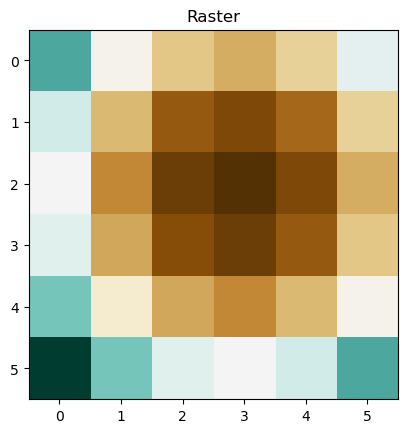

[[13776.    8586.24  5573.76  4738.56  6080.64  9600.  ]
 [10256.64  5066.88  2054.4   1219.2   2561.28  6080.64]
 [ 8914.56  3724.8    712.32  -122.88  1219.2   4738.56]
 [ 9749.76  4560.    1547.52   712.32  2054.4   5573.76]
 [12762.24  7572.48  4560.    3724.8   5066.88  8586.24]
 [17952.   12762.24  9749.76  8914.56 10256.64 13776.  ]]


In [119]:
# Generate mesh grid for rasters
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

# Generate values for mesh grid
Z1 = np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 = np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z3 = np.abs(((X + 3) + (Y - 8) ** 2) / 3 ** 2)

# Generate raster values
Z = (Z1 - Z2)

# Set transform
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

# Save first raster
with rasterio.open(
        os.getcwd() + "/data/window_raster.tif",
        mode = "w",
        driver = "GTiff",
        height = Z.shape[0],
        width = Z.shape[1],
        count = 1,
        dtype = Z.dtype,
        crs = "+proj=latlong",
        transform = transform,
) as new_dataset:
        new_dataset.write(Z, 1)

# Open and read raster
src = rasterio.open(os.getcwd() + "/data/window_raster.tif")
raster = src.read(1)

# Plot raster
plt.imshow(raster, cmap="BrBG")
plt.title("Raster")
plt.show()

# Show raster values
print(raster)

### Create kernel

Second, we can **generate a kernel array**. The array can consist of a single value or multiple values. Below, we generate a `3x3` kernel consisting of the value `1/9`. This kernel will output the average value of the center cell and its surrounding eight neighbors.

Important - The kernel should have an odd number of rows and columns and should not have more rows and columns than the input raster.

Tip - To create a non-rectangular shape, simply add `0`s in the kernel positions to be ignored.

In [106]:
# Create a kernel to calculate the average
kernel = np.full((3, 3), 1/9)

# Get kernel shape
kernel_shape = kernel.shape

# Convert the kernel to a flattened array
kernel_array = np.ravel(kernel)

### Create output arrays

Next, we will create two arrays that will store our calculations.

The first array is the output array, which has the same shape as that of the input raster. We will initially fill the array with placeholder values. This array will be the final result that is exported and saved.

In [107]:
# Create raster array with placeholder values in shape of raster
output_rio = np.full((raster.shape[0], raster.shape[1]), -9999)

# Set array data type
output_rio = output_rio.astype(np.float64) ###

# Display raster array with placeholder values
print(output_rio)

[[-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]
 [-9999. -9999. -9999. -9999. -9999. -9999.]]


The second array, initially filled with `0`s, will hold the pixel value as calculated from the vectorized sliding windows (e.g., mean). Since we are not performing calculations on any edge pixels, the shape of this array is slightly smaller than that of the input raster and also dependent on the shape of the kernel. This array will be inserted into and replace the non-edge placeholder values in the output array (which we just created).

In [108]:
# Create raster array used to store window operation calculations for each pixel (excluding boundary pixels)
aggregate = np.full((raster.shape[0] - kernel_shape[0] + 1, raster.shape[1] - kernel_shape[1] + 1), 0)

# Set array data type
aggregate = aggregate.astype(np.float64)

# Display raster array
print(aggregate)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Create vectorized sliding windows

The next step is to generate the vectorized sliding windows. The shape of the vectorized sliding windows depends on the kernel shape, so we utilize indices and slicing to obtain the extent of a vectorized sliding window for each position in the kernel.

In [109]:
# Generate row index pairs for slicing
pairs_x = list(zip([None] + list(np.arange(1, kernel_shape[0])), list(np.arange(-kernel_shape[0] + 1, 0)) + [None]))

# Generate column index pairs for slicing
pairs_y = list(zip([None] + list(np.arange(1, kernel_shape[1])), list(np.arange(-kernel_shape[1] + 1, 0)) + [None]))

# Combine row and column index pairs together to get the extent for each vectorized sliding window
combos = list(product(pairs_x, pairs_y))

# Display combined pairs
print(combos)

[((None, -2), (None, -2)), ((None, -2), (1, -1)), ((None, -2), (2, None)), ((1, -1), (None, -2)), ((1, -1), (1, -1)), ((1, -1), (2, None)), ((2, None), (None, -2)), ((2, None), (1, -1)), ((2, None), (2, None))]


### Apply vectorized sliding window

Once the vectorized sliding windows are specified, we can apply them to the raster. The vectorized sliding window will get a subset of the raster array, and we can multiply all the pixel values in that subset by the corresponding value in the kernel, which is based on window’s specific kernel position.

The product is then added to the array that keeps track of the running total.

In [121]:
# Create empty list to store each window operation calculation
sub_array_list = []

# Iterate through the combined pairs (which give extent of a sliding window)
for p in range(len(combos)):
    # Get the sub-array via slicing and multiply all the values by corresponding value in kernel (based on location)
    sub_array = raster[combos[p][0][0]:combos[p][0][1], combos[p][1][0]:combos[p][1][1]] * kernel_array[p]

    # Add sub-array values to array storing window operation calculations
    aggregate += sub_array

    # Add sub-array to list
    sub_array_list.append(sub_array)

# View array storing window operation calculations
print(aggregate)

[[6518.4  3505.92 2670.72 4012.8 ]
 [5176.32 2163.84 1328.64 2670.72]
 [6011.52 2999.04 2163.84 3505.92]
 [9024.   6011.52 5176.32 6518.4 ]]


Once we get the aggregate of all windows, we can perform additional computations. In this case, we multiply all values by `2`.

In [122]:
# Get average value
aggregate = aggregate * 2

# View array storing window operation calculations
print(aggregate)

[[13036.8   7011.84  5341.44  8025.6 ]
 [10352.64  4327.68  2657.28  5341.44]
 [12023.04  5998.08  4327.68  7011.84]
 [18048.   12023.04 10352.64 13036.8 ]]


### Window operations with predefined functions

We can also perform window operations with predefined functions, such as getting the maximum value of a pixel and its surrounding pixels. We simply take the calculations from each vectorized sliding window and get the maximum value from those calculations.

Tip - To get the maximum or minimum value of a pixel and its surrounding neighbors, the kernel should be filled with values of 1 so that the pixel values don’t change.

In [123]:
# Get maximum value
window_maximum = np.maximum.reduce(sub_array_list)
print(window_maximum)

[[1530.66666667  954.02666667  675.62666667 1066.66666667]
 [1139.62666667  562.98666667  284.58666667  675.62666667]
 [1418.02666667  841.38666667  562.98666667  954.02666667]
 [1994.66666667 1418.02666667 1139.62666667 1530.66666667]]


### Save output

We can insert the processed aggregate array into the output array, with each value replacing the placeholder value at its corresponding original position in the array. Recall that because edge pixels are ignored, the edge pixels of the output array will still keep their placeholder values.

In this example, each non-edge output pixel value is the average pixel value–with pixel values drawn from the input raster–of the 8 pixels surrounding that pixel and the pixel itself.

In [124]:
# Use kernel shape to determine the row and column index extent of the calculated array
n = int((kernel_shape[0] - 1) / 2)
m = int((kernel_shape[1] - 1) / 2)

# Replace placeholder values in the output array with the corresponding values (based on location) from the calculated array
output_rio[n: -n, m: -m] = aggregate

# Display output array
print(output_rio)

[[-9999.   -9999.   -9999.   -9999.   -9999.   -9999.  ]
 [-9999.   13036.8   7011.84  5341.44  8025.6  -9999.  ]
 [-9999.   10352.64  4327.68  2657.28  5341.44 -9999.  ]
 [-9999.   12023.04  5998.08  4327.68  7011.84 -9999.  ]
 [-9999.   18048.   12023.04 10352.64 13036.8  -9999.  ]
 [-9999.   -9999.   -9999.   -9999.   -9999.   -9999.  ]]


In [125]:
# Export raster
with rasterio.open(
        os.getcwd() + "/data/raster_window_3x3_average.tif", "w",
        driver = "GTiff",
        transform = src.transform,
        dtype = rasterio.float64,
        count = 1,
        width = src.width,
        height = src.height) as dst:
    dst.write(output_rio, indexes = 1)

## Window operations with GeoWombat

We can use `GeoWombat` for window operations if we’re only interested in calculating a statistic. The code to do this with `GeoWombat` is less complex and much shorter than with `rasterio` –- we can simply use the `geowombat.moving()` function.

The `geowombat.moving()` function provides us with a few parameters that we can specify:
| Parameter | Description |
| --- | --- |
| `stat` | Statistic calculated (options: mean, standard deviation, variance, minimum, maximum, percentile) |
| `perc` | Percentile used for window operation if `stat = perc` |
| `w` | Moving window size in pixels |
| `nodata` | Value that will be ignored in calculations |

In [126]:
# # Open file
# with gw.open(os.getcwd() + '/data/window_raster.tif') as src:
#     # Create plot
#     fig, ax = plt.subplots(dpi = 200)

#     # Calculate local average
#     output_gw = src.gw.moving(stat = 'mean', w = 5, n_jobs = 4, nodata = 0)
#     print(output_gw)

#     # Plot raster
#     output_gw.sel(band = 1).gw.imshow(robust = True, ax = ax)
#     plt.tight_layout(pad = 1)